In [1]:
%matplotlib inline
from __future__ import division

import pandas as pd
import matplotlib.pyplot as plt
import utils

In [2]:
visitors, events, devices, url_categories = utils.load_data()

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (5,6,7,8,11,12,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
categorized_events = utils.categorize_events(events, url_categories)

match rate: 98.9204202175%


In [3]:
sample_npis = list(visitors[(visitors.professional_designation=='Physician')\
                       &(~visitors.npi_number.isnull())\
                       &(visitors.exclude==0)].npi_number.sample(10000))

In [4]:
def categorize_frequency(n):
    if n < 1:
        return 'Less than 1 visit a month' 
    elif n <= 10:
        return '1-10 times per month'
    else:
        return 'More than 10x per month'

In [14]:
def summary_statistics(npis):
    import matplotlib.pyplot as plt
    
    v = visitors[visitors.npi_number.isin(npis)]
    ev = pd.merge(v, events, on='dg_id')
    
    # number with web activity
    v['has_event'] = v.dg_id.apply(lambda x: 1 if x in set(ev.dg_id) else 0)
    with_event = v[v.has_event==1].dg_id.nunique()
    total_npis = v.dg_id.nunique()

    print "{} of the {}, or {}%, of NPI numbers submitted have web activity"\
        .format(with_event, total_npis, with_event/total_npis*100)
        
    #fig, axs = plt.subplots(1,2, figsize=(15,6))

    # frequency of usage
    max_dt = max(events.timestamp).date()
    ev['dt'] = ev.timestamp.apply(lambda x: x.date())
    freq = ev.drop_duplicates(subset=['dg_id', 'dt']).groupby(['dg_id']).dt.agg(['min', 'max', 'count']).reset_index()
    freq['sessions_per_month'] = freq.apply(lambda x: x['count']/(max(1, (max_dt-x['min']).days)/30), axis=1)
    freq['category'] = freq.sessions_per_month.apply(lambda x: categorize_frequency(x))
    freq.groupby('category').dg_id.count().plot.bar()
    plt.show()
    
    # specialty breakdown
    vfreq = pd.merge(v, freq[['dg_id', 'sessions_per_month']], on='dg_id')
    vfreq[vfreq.has_event==1].groupby('primary_specialty').dg_id.count().sort_values(ascending=False)[:10].plot.pie(figsize=(6,6))
    plt.show()
    
    # frequency by specialty
    
    specialty_frequency = vfreq.groupby('primary_specialty').sessions_per_month.agg(['count', 'mean'])\
                            .loc[lambda x: x['count']>=10].sort_values('mean').reset_index()
    
    print '{} is the least active specialty, with an average of {} sessions per month.\n'\
        .format(specialty_frequency.primary_specialty[0], round(specialty_frequency['mean'][0],2))
    print '{} is the least active specialty, with an average of {} sessions per month.\n'\
        .format(specialty_frequency.primary_specialty[len(specialty_frequency)-1], round(specialty_frequency['mean'][len(specialty_frequency)-1],2))
        
    # pages per session
    urls_per_session = ev.groupby(['dg_id', 'session_id']).url.nunique().reset_index().groupby('dg_id').url.mean().reset_index()
    print '{}% of doctors visit more than one page per sessions, with an average of {} pages.\n'\
        .format(round(len(urls_per_session[urls_per_session.url>1])/len(urls_per_session)*100,2), round(urls_per_session.url.mean(),2))
    
    # url categories
    catev = utils.categorize_events(ev, url_categories)
    catev = catev.fillna('')
    catev['site_site_sub_category'] = catev.apply(lambda x: x.site_category + ': ' + x.site_sub_category, axis=1)
    catev.groupby('site_site_sub_category').session_id_x.nunique().plot.bar(figsize=(12,6))
    plt.show()
    
    site_category_breakdown = \
        catev.groupby(['site_category', 'site_sub_category'])\
        .session_id_x.nunique().reset_index().sort_values('session_id_x', ascending=False)\
        .rename(columns={'session_id_x':'cnt'})

    # pharma stuff
    catev[catev.site_category=='Pharma'].groupby('disease_category').session_id_x.nunique().plot.bar(figsize=(12,6))
    plt.show()
    
    disease_category_breakdown = \
        catev[catev.site_category=='Pharma'].groupby(['primary_specialty','disease_category'])\
        .session_id_x.nunique().reset_index().sort_values('session_id_x', ascending=False)\
        .rename(columns={'session_id_x':'cnt'})

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


651 of the 10000, or 6.51%, of NPI numbers submitted have web activity


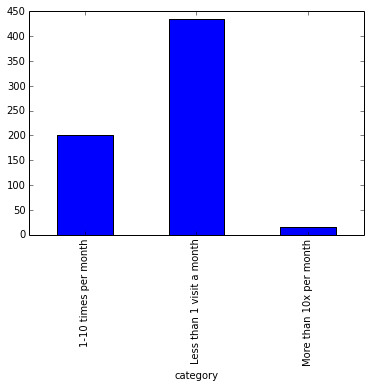

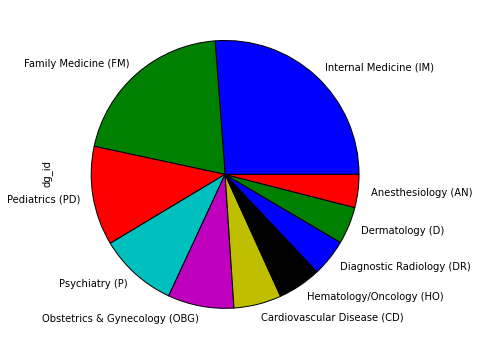

Anesthesiology (AN) is the least active specialty, with an average of 0.59 sessions per month.

Endocrinology, Diabetes, Metabolism (END) is the least active specialty, with an average of 3.13 sessions per month.

62.52% of doctors visit more than one page per sessions, with an average of 1.71 pages.



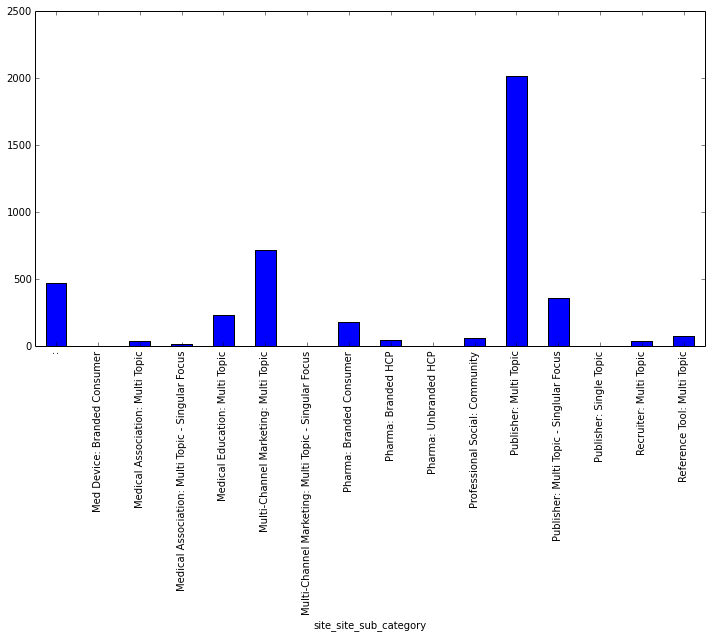

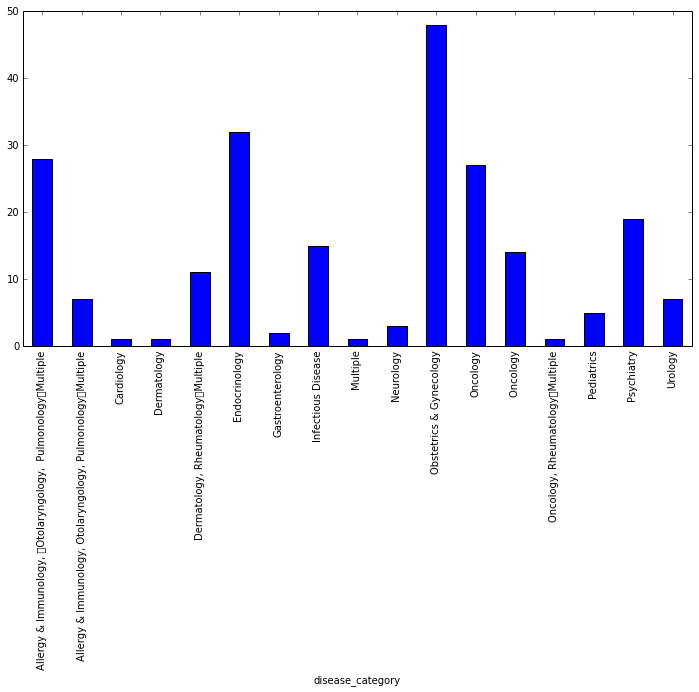

In [15]:
summary_statistics(sample_npis)

In [29]:
freq

NameError: name 'freq' is not defined

In [7]:
v = visitors[visitors.npi_number.isin(npis)]
ev = pd.merge(v, events, on='dg_id')

# number with web activity
v['has_event'] = v.dg_id.apply(lambda x: 1 if x in set(ev.dg_id) else 0)
with_event = v[v.has_event==1].dg_id.nunique()
total_npis = v.dg_id.nunique()

print "{} of the {}, or {}%, of NPI numbers submitted have web activity"\
    .format(with_event, total_npis, with_event/total_npis*100)

#fig, axs = plt.subplots(1,2, figsize=(15,6))

# frequency of usage
max_dt = max(events.timestamp).date()
ev['dt'] = ev.timestamp.apply(lambda x: x.date())
freq = ev.drop_duplicates(subset=['dg_id', 'dt']).groupby(['dg_id']).dt.agg(['min', 'max', 'count']).reset_index()
freq['sessions_per_month'] = freq.apply(lambda x: x['count']/(max(1, (max_dt-x['min']).days)/30), axis=1)
freq['category'] = freq.sessions_per_month.apply(lambda x: categorize_frequency(x))
freq.groupby('category').dg_id.count().plot.bar()
plt.show()

# specialty breakdown
vfreq = pd.merge(v, freq[['dg_id', 'sessions_per_month']], on='dg_id')
vfreq[vfreq.has_event==1].groupby('primary_specialty').dg_id.count().sort_values(ascending=False)[:10].plot.pie(figsize=(6,6))
plt.show()

# frequency by specialty

specialty_frequency = vfreq.groupby('primary_specialty').sessions_per_month.agg(['count', 'mean'])\
                        .loc[lambda x: x['count']>=10].sort_values('mean').reset_index()

print '{} is the least active specialty, with an average of {} sessions per month.\n'\
    .format(specialty_frequency.primary_specialty[0], round(specialty_frequency['mean'][0],2))
print '{} is the least active specialty, with an average of {} sessions per month.\n'\
    .format(specialty_frequency.primary_specialty[len(specialty_frequency)-1], round(specialty_frequency['mean'][len(specialty_frequency)-1],2))

# pages per session
urls_per_session = ev.groupby(['dg_id', 'session_id']).url.nunique().reset_index().groupby('dg_id').url.mean().reset_index()
print '{}% of doctors visit more than one page per sessions, with an average of {} pages.\n'\
    .format(round(len(urls_per_session[urls_per_session.url>1])/len(urls_per_session)*100,2), round(urls_per_session.url.mean(),2))

# url categories
catev = utils.categorize_events(ev, url_categories)
catev = catev.fillna('')
catev['site_site_sub_category'] = catev.apply(lambda x: x.site_category + ': ' + x.site_sub_category, axis=1)
catev.groupby('site_site_sub_category').session_id_x.nunique().plot.bar(figsize=(12,6))
plt.show()

site_category_breakdown = \
    catev.groupby(['site_category', 'site_sub_category'])\
    .session_id_x.nunique().reset_index().sort_values('session_id_x', ascending=False)\
    .rename(columns={'session_id_x':'cnt'})

# pharma stuff
catev[catev.site_category=='Pharma'].groupby('disease_category').session_id_x.nunique().plot.bar(figsize=(12,6))
plt.show()

disease_category_breakdown = \
    catev[catev.site_category=='Pharma'].groupby(['primary_specialty','disease_category'])\
    .session_id_x.nunique().reset_index().sort_values('session_id_x', ascending=False)\
    .rename(columns={'session_id_x':'cnt'})

In [40]:
v = visitors[visitors.npi_number.isin(sample_npis)]
ev = pd.merge(v, events, on='dg_id')
urls_per_session = ev.groupby(['dg_id', 'session_id']).url.nunique().reset_index().groupby('dg_id').url.mean().reset_index()
ev = utils.categorize_events(ev, url_categories)

In [43]:
urls_per_session.columns = ['dg_id', 'pages_per_session']

In [36]:
ev['authorized'] = ev.identity_type.apply(lambda x: 1 if x == 'AUT' else 0)
v['has_event'] = v.dg_id.apply(lambda x: 1 if x in set(ev.dg_id) else 0)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [57]:
tableau

,Unnamed: 0,dg_id,identity_type,professional_designation,npi_number,primary_specialty,primary_specialty_group,secondary_specialty,secondary_specialty_group,first_name,...,suspected_bot,exclude,min,max,count,sessions_per_month,category,pages_per_session,disease_category,site_category
0,637190,U080005719,AUT,Physician,1.508956e+09,Anatomic Pathology (ATP),Pathology,Clinical Pathology (CLP),Pathology,MICHAEL,...,N,0,2017-02-16,2017-02-16,1,0.188679,Less than 1 visit a month,1.000000,Multiple,Publisher
1,640790,U080009358,AUT,Physician,1.487626e+09,Rheumatology (RHU),Internal Medicine,Internal Medicine (IM),Internal Medicine,RONALD,...,N,0,2017-07-13,2017-07-13,1,2.500000,1-10 times per month,2.000000,Multiple,Publisher
2,641243,U080009811,AUT,Physician,1.568644e+09,General Surgery (GS),Surgery,Unspecified (US),Other,LAURA,...,N,0,2017-03-29,2017-03-29,1,0.254237,Less than 1 visit a month,2.000000,Multiple,Multi-Channel Marketing
3,641474,U080010043,AUT,Physician,1.134340e+09,Internal Medicine (IM),Internal Medicine,Unspecified (US),Other,FRANK,...,N,0,2017-06-29,2017-07-24,3,3.461538,1-10 times per month,3.000000,Multiple,Recruiter
4,643154,U080011727,AUT,Physician,1.003845e+09,Gastroenterology (GE),Internal Medicine,Unspecified (US),Other,GARETH,...,N,0,2017-04-24,2017-04-24,1,0.326087,Less than 1 visit a month,2.000000,Multiple,Publisher
5,650609,U080019188,AUT,Physician,1.023218e+09,Internal Medicine (IM),Internal Medicine,Unspecified (US),Other,CAROLYN,...,N,0,2017-03-10,2017-03-13,2,0.437956,Less than 1 visit a month,2.000000,Multiple,Multi-Channel Marketing
6,652905,U080021535,AUT,Physician,1.609820e+09,Neurological Surgery (NS),Neurological Surgery,Unspecified (US),Other,JORDAN,...,N,0,2017-03-09,2017-06-14,11,2.391304,1-10 times per month,1.071429,Multiple,Multi-Channel Marketing
7,653363,U080022007,AUT,Physician,1.972586e+09,Radiation Oncology (RO),Radiology,Unspecified (US),Other,JOSEPH,...,N,0,2017-02-15,2017-06-20,6,1.125000,1-10 times per month,1.833333,Multiple,Publisher
8,653697,U080022341,AUT,Physician,1.578790e+09,Internal Medicine (IM),Internal Medicine,Unspecified (US),Other,MORGAN,...,N,0,2017-02-16,2017-05-18,2,0.377358,Less than 1 visit a month,1.000000,Multiple,Publisher
9,653754,U080022398,AUT,Physician,1.194050e+09,Pediatrics (PD),Pediatrics,Unspecified (US),Other,ERIN,...,N,0,2017-03-16,2017-03-16,1,0.229008,Less than 1 visit a month,1.000000,Multiple,Multi-Channel Marketing


In [55]:
tableau = pd.merge(v, freq, on='dg_id')
tableau = pd.merge(tableau, urls_per_session, on='dg_id')
tableau = pd.merge(tableau, disease_types[['dg_id', 'disease_category']], on='dg_id')
tableau = pd.merge(tableau, site_types[['dg_id', 'site_category']], on='dg_id')


In [60]:
tableau[['dg_id', 'npi_number', 'primary_specialty', 'sessions_per_month', 'category', 'pages_per_session', 'disease_category', 'site_category']].to_csv('sample_for_tableau_dg_id.csv')

In [52]:
site_types = ev.groupby(['dg_id', 'site_category']).session_id_y.nunique().reset_index().sort_values(['dg_id', 'session_id_y'], ascending=False).drop_duplicates(subset='dg_id')

In [53]:
disease_types = ev.groupby(['dg_id', 'disease_category']).session_id_y.nunique().reset_index().sort_values(['dg_id', 'session_id_y'], ascending=False).drop_duplicates(subset='dg_id')

In [54]:
disease_types.columns = ['dg_id', 'disease_category']

,dg_id,disease_category,session_id_y
863,U085067685,Multiple,2
862,U082674877,Multiple,1
861,U082612569,Multiple,2
860,U082545730,Multiple,2
859,U082543459,Multiple,2
856,U082519463,"Allergy & Immunology, \rOtolaryngology, Pulmo...",1
855,U082418081,Multiple,2
854,U082400266,Multiple,1
853,U082391140,Psychiatry,2
852,U081401890,Multiple,1


In [31]:
max_dt = max(events.timestamp).date()
ev['dt'] = ev.timestamp.apply(lambda x: x.date())
freq = ev.drop_duplicates(subset=['dg_id', 'dt']).groupby(['dg_id']).dt.agg(['min', 'max', 'count']).reset_index()
freq['sessions_per_month'] = freq.apply(lambda x: x['count']/(max(1, (max_dt-x['min']).days)/30), axis=1)
freq['category'] = freq.sessions_per_month.apply(lambda x: categorize_frequency(x))

In [35]:
pd.merge(v, freq[['dg_id', 'sessions_per_month', 'category']], on='dg_id'
        )

,Unnamed: 0,dg_id,identity_type,professional_designation,npi_number,primary_specialty,primary_specialty_group,secondary_specialty,secondary_specialty_group,first_name,...,state,zipcode,birth_year,grad_year,grad_school,gender,suspected_bot,exclude,sessions_per_month,category
0,637190,U080005719,AUT,Physician,1.508956e+09,Anatomic Pathology (ATP),Pathology,Clinical Pathology (CLP),Pathology,MICHAEL,...,CA,94305-2296,1943,1971,"STANFORD UNIV SCH OF MED, STANFORD CA 94305",M,N,0,0.188679,Less than 1 visit a month
1,640790,U080009358,AUT,Physician,1.487626e+09,Rheumatology (RHU),Internal Medicine,Internal Medicine (IM),Internal Medicine,RONALD,...,CA,90064-2318,1951,1977,"D GEFFEN SCH OF MED-UCLA, LOS ANGELES CA 90095",M,N,0,2.500000,1-10 times per month
2,641243,U080009811,AUT,Physician,1.568644e+09,General Surgery (GS),Surgery,Unspecified (US),Other,LAURA,...,CO,80906-3300,1963,1989,"UNIV OF AZ COLL OF MED, TUCSON AZ 85724",F,N,0,0.254237,Less than 1 visit a month
3,641474,U080010043,AUT,Physician,1.134340e+09,Internal Medicine (IM),Internal Medicine,Unspecified (US),Other,FRANK,...,CO,80209-3119,1956,1986,"UNIV OF CO SCH OF MED, DENVER CO 80262",M,N,0,3.461538,1-10 times per month
4,643154,U080011727,AUT,Physician,1.003845e+09,Gastroenterology (GE),Internal Medicine,Unspecified (US),Other,GARETH,...,CO,80229-2050,1962,1988,"UNIV OF CO SCH OF MED, DENVER CO 80262",M,N,0,0.326087,Less than 1 visit a month
5,650609,U080019188,AUT,Physician,1.023218e+09,Internal Medicine (IM),Internal Medicine,Unspecified (US),Other,CAROLYN,...,CA,92021-7808,1962,2005,"MIDWESTERN UNIV, AZ COLL OF OSTEO MED, GLENDAL...",F,N,0,0.437956,Less than 1 visit a month
6,652905,U080021535,AUT,Physician,1.609820e+09,Neurological Surgery (NS),Neurological Surgery,Unspecified (US),Other,JORDAN,...,NM,87594-3468,1934,1960,"UNIV OF AL SCH OF MED, BIRMINGHAM AL 35294",M,N,0,2.391304,1-10 times per month
7,653363,U080022007,AUT,Physician,1.972586e+09,Radiation Oncology (RO),Radiology,Unspecified (US),Other,JOSEPH,...,CA,94920-2011,1961,1988,"D GEFFEN SCH OF MED-UCLA, LOS ANGELES CA 90095",M,N,0,1.125000,1-10 times per month
8,653697,U080022341,AUT,Physician,1.578790e+09,Internal Medicine (IM),Internal Medicine,Unspecified (US),Other,MORGAN,...,CA,93001-3911,1979,2009,"MIDWESTERN UNIV, AZ COLL OF OSTEO MED, GLENDAL...",F,N,0,0.377358,Less than 1 visit a month
9,653754,U080022398,AUT,Physician,1.194050e+09,Pediatrics (PD),Pediatrics,Unspecified (US),Other,ERIN,...,NV,89084-2623,1980,2010,"MIDWESTERN UNIV, AZ COLL OF OSTEO MED, GLENDAL...",F,N,0,0.229008,Less than 1 visit a month


In [34]:
freq[['dg_id', 'sessions_per_month', 'category']]

,dg_id,sessions_per_month,category
0,U080005719,0.188679,Less than 1 visit a month
1,U080009358,2.500000,1-10 times per month
2,U080009811,0.254237,Less than 1 visit a month
3,U080010043,3.461538,1-10 times per month
4,U080011727,0.326087,Less than 1 visit a month
5,U080019188,0.437956,Less than 1 visit a month
6,U080021535,2.391304,1-10 times per month
7,U080022007,1.125000,1-10 times per month
8,U080022341,0.377358,Less than 1 visit a month
9,U080022398,0.229008,Less than 1 visit a month


In [28]:
ev[['dg_id', 'authorized', 'identity_type', 'npi_number', 'primary_specialty', 'timestamp', 'site_category', 'site_sub_category', 'disease_category', 'disease']].to_csv('sample_for_tableau.csv')

In [28]:
site_category_breakdown = \
    catev.groupby(['site_category', 'site_sub_category'])\
    .session_id_x.nunique().reset_index().sort_values('session_id_x', ascending=False)\
    .rename(columns={'session_id_x':'cnt'})

In [29]:
disease_category_breakdown = \
    catev.groupby(['site_category', 'disease_category'])\
    .session_id_x.nunique().reset_index().sort_values('session_id_x', ascending=False)\
    .rename(columns={'session_id_x':'cnt'})

In [36]:
disease_category_breakdown = \
    catev[catev.site_category=='Pharma'].groupby(['primary_specialty','disease_category'])\
    .session_id_x.nunique().reset_index().sort_values('session_id_x', ascending=False)\
    .rename(columns={'session_id_x':'cnt'})

In [37]:
disease_category_breakdown

,primary_specialty,disease_category,cnt
34,Hematology/Oncology (HO),Obstetrics & Gynecology,16
77,Psychiatry (P),Obstetrics & Gynecology,10
71,Pediatrics (PD),Obstetrics & Gynecology,9
57,Obstetrics & Gynecology (OBG),Obstetrics & Gynecology,8
35,Hematology/Oncology (HO),Oncology,8
19,Family Medicine (FM),Gastroenterology,7
39,Internal Medicine (IM),Endocrinology,6
86,Vascular Surgery (VS),Obstetrics & Gynecology,5
46,Internal Medicine (IM),Oncology,5
48,Internal Medicine (IM),Pediatrics,4


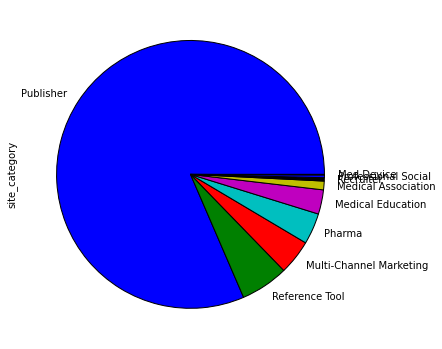

In [184]:
url_events.site_category.value_counts().plot.pie(figsize=(6,6))

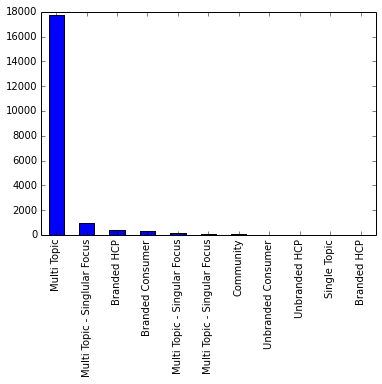

In [191]:
url_events.site_sub_category.value_counts().plot.bar()

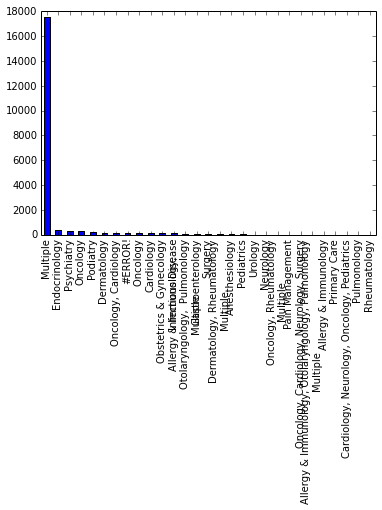

In [192]:
url_events.disease_category.value_counts().plot.bar()

In [185]:
url_categories.groupby(['url_root', 'disease_category')

,url,site_category,site_sub_category,disease_category,disease,url_root
0,http://www.paradigmspine.com/content/are-you-a...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
1,http://www.paradigmspine.com/content/back-spin...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
2,http://www.paradigmspine.com/content/coflex-study,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
3,http://www.paradigmspine.com/content/degenerat...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
4,http://www.paradigmspine.com/content/degenerat...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
5,http://www.paradigmspine.com/content/glossary,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
6,http://www.paradigmspine.com/content/patients-...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
7,http://www.paradigmspine.com/content/patient-t...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
8,http://www.paradigmspine.com/content/spinal-st...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
9,http://www.paradigmspine.com/content/spondylol...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine


In [193]:
url_categories[url_categories.site_category=='Pharma'].url_root.value_counts()

merckconnect                      11
revlimid                           4
merckvaccines                      4
eliquis                            3
merck                              3
tarceva                            2
herceptin                          2
ocrevus                            2
erivedge                           2
adempas-us                         2
journeyforcontrol                  2
alecensa                           2
lenvima                            2
keytruda                           2
tyvaso                             2
cotellic                           2
cabometyx                          2
astellasclinicalstudyresults       2
gazyva                             2
merckaccessprogram-zepatier        2
kadcyla                            2
merckclarifiesbiosimilars          2
tecentriq                          2
rituxan                            2
perjeta                            2
empliciti                          1
venclexta                          1
a

In [194]:
url_categories[url_categories.url_root=='nuvaring']

,url,site_category,site_sub_category,disease_category,disease,url_root
112,www.nuvaring.com,Pharma,Branded Consumer,#ERROR!,Birth Control,nuvaring


In [ ]:
"once a monther vs frequent users, types of content based on this"
"summary table"